Import libraries

In [3]:
# import library
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import cv2
import wandb
import numpy as np
# from evaluate import evaluate
# from unet import UNet
# from utils.data_loading import BasicDataset, CarvanaDataset
# from utils.dice_score import dice_loss

In [4]:
# dir_img = Path('./data/carvana-image-masking-challenge/train_hq/')
# dir_mask = Path('./data/carvana-image-masking-challenge/train_masks/')
dir_img = Path(r'dataset\detection\JPEGImages'.replace('\\', '/'))
dir_xml = Path(r'dataset\detection\Annotations'.replace('\\', '/'))
dir_checkpoint = Path('./checkpoints/')

Data loader

In [82]:
import pathlib
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image  # 引入 PIL 庫
import matplotlib.pyplot as plt

def parse_xml_annotation(xml_file):
    """
    解析 XML 標註文件，返回圖像文件名和 bounding box 資訊。
    
    :param xml_file: XML 文件的路徑
    :return: 包含文件名和 bounding box 的字典 {'file': 'image_name.jpg', 'bboxes': [[xmin, ymin, xmax, ymax], ...]}
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text
    bboxes = []
    
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bboxes.append([xmin, ymin, xmax, ymax])
    
    return {'file': filename, 'bboxes': bboxes}

class UNetDatasetWithBoundingBoxes(Dataset):
    def __init__(self, img_dir: str, xml_dir: str, transform = None, img_scale: float = 1.0, mask_suffix: str = ''):
        """
        :param img_dir: 圖片目錄的路徑
        :param xml_dir: 標註 XML 文件的目錄
        :param transform: 圖片轉換操作
        :param img_scale: 圖片的目標大小 * scale
        """
        self.img_dir = img_dir
        self.xml_dir = xml_dir
        self.transform = transform
        self.img_scale = img_scale
        self.annotations = self.load_annotations()
        self.mask_suffix = mask_suffix

        return 
    
    def load_annotations(self):
        annotations = []
        for xml_file in os.listdir(self.xml_dir):
            if xml_file.endswith('.xml'):
                annotation = parse_xml_annotation(os.path.join(self.xml_dir, xml_file))
                annotations.append(annotation)
        return annotations

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        # get bounding box
        annotation = self.annotations[index]
        img_path = os.path.join(self.img_dir, annotation['file'])     
        bboxes = annotation['bboxes']

        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # not necessary
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        
                # 使用每個 bounding box 畫出矩形
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            print(bbox)
            cv2.rectangle(mask, (xmin, ymin), (xmax, ymax), color=1, thickness=-1) 

        # print((mask))
        # plt.show(mask.any())   

        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        # 重新調整圖片和 mask 的大小
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)

        return {
            'image': img,
            'mask': mask
        }


In [ ]:
# 定義轉換操作
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 調整到所需大小
    transforms.ToTensor()  # 轉換為 PyTorch 張量
])

# 設定圖片和 XML 標註文件的目錄
image_dir = '/path/to/images'
xml_dir = '/path/to/annotations'

# 實例化數據集
dataset = UNetDatasetWithBoundingBoxes(img_dir=image_dir, xml_dir=xml_dir, transform=transform)

# 創建 DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 示例：遍歷 DataLoader
for batch in dataloader:
    images, masks = batch['image'], batch['mask']
    print(images.shape, masks.shape)

[200, 90, 216, 108]


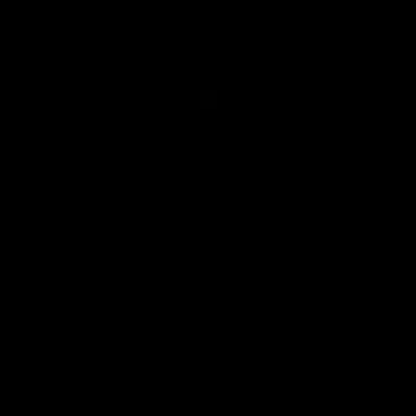

In [83]:
dataset = UNetDatasetWithBoundingBoxes(dir_img, dir_xml)
dataset[10]['mask']
# dataset[10]['image']

IndexError: list index out of range

Data Loader
1. transfer xml and image to data
2. 

In [5]:
# import pathlib
# import xml.etree.ElementTree as ET
# import cv2
# import matplotlib.pyplot as plt

# ROOT_PATH = '/home/ddd/Desktop/D_codes/ML/dataset' # fill the dir where you place the dataset

# def vis_label(image_name,purpose,fs=10):
#     xml_path = pathlib.Path(ROOT_PATH,purpose,'Annotations',image_name).with_suffix('.xml')
#     label = ET.parse(xml_path).getroot()
#     xmin = int(label.find('object').find('bndbox').find('xmin').text)
#     ymin = int(label.find('object').find('bndbox').find('ymin').text)
#     xmax = int(label.find('object').find('bndbox').find('xmax').text)
#     ymax = int(label.find('object').find('bndbox').find('ymax').text)

#     image_path = pathlib.Path(ROOT_PATH,purpose,'JPEGImages',image_name).with_suffix('.jpg')
#     # image = plt.imread(image_path)
#     image = cv2.imread(image_path)

#     cv2.rectangle(image,[xmin,ymin],[xmax,ymax],(255,0,0),1)

#     plt.figure(figsize=(fs,fs))
#     plt.imshow(image)
#     plt.show()

# wrong_label = []
# rectangle_bbox = []

# for purpose in ['detection','tracking']:
#     root_path = pathlib.Path(ROOT_PATH,purpose,'Annotations')
#     for xml_path in sorted(root_path.iterdir()):
#         label = ET.parse(xml_path).getroot()
#         H = int(label.find('size').find('height').text)
#         W = int(label.find('size').find('width').text)

#         xmin = float(label.find('object').find('bndbox').find('xmin').text)
#         ymin = float(label.find('object').find('bndbox').find('ymin').text)
#         xmax = float(label.find('object').find('bndbox').find('xmax').text)
#         ymax = float(label.find('object').find('bndbox').find('ymax').text)

#         if (xmin<0)|(ymin<0)|(xmax>=W)|(ymax>=H)|(xmin>xmax)|(ymin>ymax):
#             wrong_label.append([xml_path,xmin,xmax,ymin,ymax,H,W])

#         if not (1/2 < abs(xmax-xmin)/abs(ymax-ymin) < 2):
#             rectangle_bbox.append([xml_path,xmin,xmax,ymin,ymax])

# print(len(rectangle_bbox)) #count 105
# print(len(wrong_label)) #count 5

# for w in wrong_label:
#     vis_label(w[0].with_suffix('').name,w[0].parent.parent.name)

# for r in rectangle_bbox:
#     vis_label(r[0].with_suffix('').name,r[0].parent.parent.name,5)